In [1]:
#import packages
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import scipy.signal as signal

C:\Users\yijan\anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\yijan\anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.1, the latest is 0.6.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
# Load data
import mne
raw = mne.io.read_raw_edf('../EEG_recordings/346/Default_2022-09-21_10_00_27_export_346.edf', preload=True)
raw

Extracting EDF parameters from D:\Makinson_lab\sleep\EEG_recordings\346\Default_2022-09-21_10_00_27_export_346.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 86650879  =      0.000 ... 84619.999 secs...


<RawEDF | Default_2022-09-21_10_00_27_export_346.edf, 3 x 86650880 (84620.0 s), ~1.94 GB, data loaded>

In [3]:
#downsample
raw.resample(128)
sf = raw.info['sfreq']
print('Chan =', raw.ch_names)
print('Sampling frequency =', sf)
print('Data shape (channels, times) =', raw._data.shape)

Chan = ['EEG EEG1.1A-B', 'EEG EEG2.1A-B', 'EMG EEG3.1A-B']
Sampling frequency = 128.0
Data shape (channels, times) = (3, 10831360)


In [6]:
(128*60*60*23)+(128*60*30)+(128*20) #23hrs + 30min + 20sec

10831360

In [7]:
#load sleep scores
scores = pd.read_csv('d:/makinson_lab/sleep/EEG_recordings/346/Default_2022-09-21_10_00_27_export_346_scores.tsv', sep='\t')

In [8]:
scores

,Date,Time,Time Stamp,Time from Start,scores,Unnamed: 5
0,9/21/2022,10:00:31,44825.58369,0,1.0,...
1,9/21/2022,10:00:41,44825.58381,10,1.0,...
2,9/21/2022,10:00:51,44825.58392,20,1.0,...
3,9/21/2022,10:01:01,44825.58404,30,1.0,...
4,9/21/2022,10:01:11,44825.58416,40,1.0,...
...,...,...,...,...,...,...
8457,9/22/2022,09:30:01,44826.56251,84570,255.0,...
8458,9/22/2022,09:30:11,44826.56263,84580,255.0,...
8459,9/22/2022,09:30:21,44826.56274,84590,255.0,...
8460,9/22/2022,09:30:31,44826.56286,84600,255.0,...


In [9]:
# in sirenia sleep, 255 unscored, 1 wake, 2 NREM, 3 REM, 4 "parameters"
# in Yasa -2 = Unscored, -1 = Artefact / Movement, 0 = Wake, 1 = N1 sleep, 2 = N2 sleep, 3 = N3 sleep, 4 = REM sleep
scores_array = scores['scores']
scores_converted = []
for x in range(scores_array.shape[0]):
    if scores_array[x]==1: # wake
        scores_converted.append(0)
    elif scores_array[x]==2: # NREM
        scores_converted.append(1)
    elif scores_array[x]==3: # REM
        scores_converted.append(4)
    elif scores_array[x]==255: # unscored
        scores_converted.append(-2)

07-Dec-22 15:43:20 | WARNING | Hypnogram is SHORTER than data by 16924.00 seconds. Padding hypnogram with last value to match data.size.


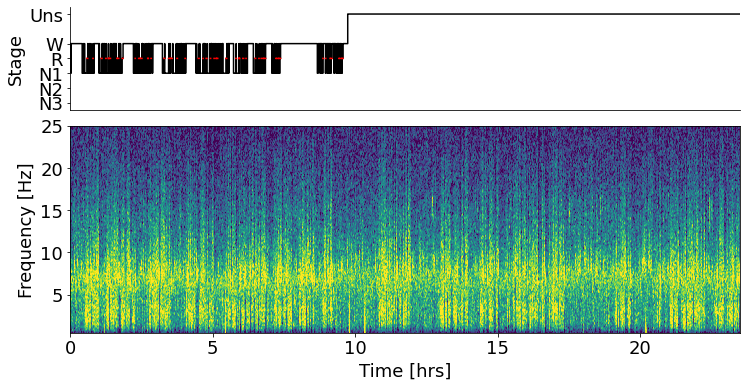

In [10]:
# sls = yasa.SleepStaging(raw, eeg_name='EEG EEG1A-B', emg_name='EMG EEG3A-B')
# hypno_pred = sls.predict()  # Predict the sleep stages
# hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
hypno_up = yasa.hypno_upsample_to_data(scores_converted, sf_hypno=1/8, data=raw, sf_data = 128)
# yasa.plot_hypnogram(hypno_pred);  # Plot
yasa.plot_spectrogram(raw._data[0], sf, hypno_up, cmap = 'viridis');
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig("day1_CH2_hypnogram.jpg")

In [53]:
all_scores = scores_converted[0:4384]

In [58]:
CH1 = []
CH2 = []
for i in range(len(all_scores)):
    CH1.append(raw._data[0][i*1280:(i+1)*1280])
    CH2.append(raw._data[1][i*1280:(i+1)*1280])

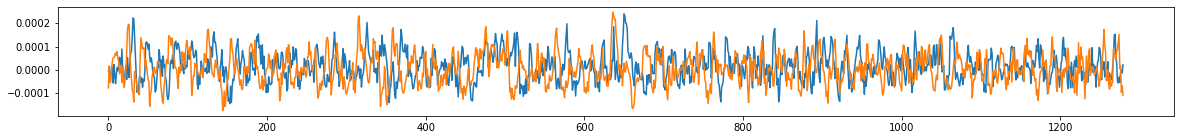

In [63]:
fig = plt.figure(figsize = (20,2))
plt.plot(CH1[4383]) 
plt.plot(CH2[4383])